# Colab Setup

In [1]:
!nvidia-smi

Sat Sep 28 07:56:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install scikit-plot --quiet

In [0]:
!apt-get -qq install -y graphviz && pip install -q pydot --quiet

# Imports and Data Setup

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv

--2019-09-28 07:56:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7635689 (7.3M) [application/x-httpd-php]
Saving to: ‘data.csv’

data.csv            100%[===================>]   7.28M  5.87MB/s    in 1.2s    

2019-09-28 07:56:48 (5.87 MB/s) - ‘data.csv’ saved [7635689/7635689]



In [0]:
!mkdir data
!mv data.csv data/data.csv

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pydot
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

import scikitplot as skplt
from pathlib import Path

from sklearn.decomposition import PCA

In [0]:
                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

In [0]:
datapath = Path('./data')

# Explore Dataset

In [0]:
raw = pd.read_csv(datapath/'data.csv', index_col=0)

In [11]:
raw.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [0]:
raw.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,-5.827478,-6.042174,-6.687304,-7.088870,-7.211217,-7.088261,-6.806696,-6.744696,-6.484783,-6.448435,-6.355391,-6.543130,-6.884348,-6.883217,-6.118870,-5.15913,-4.785652,-4.874783,-5.393565,-5.935478,-6.349913,-6.212522,-5.859826,-5.299826,-4.955652,-5.278087,-6.162261,-7.316609,-7.998522,-7.818870,...,-6.997304,-7.339391,-7.911565,-8.177304,-8.608870,-8.578087,-8.240000,-7.691391,-7.356522,-7.228783,-6.980870,-6.756783,-6.355304,-6.423826,-6.465217,-6.316435,-5.808000,-5.255913,-4.682087,-4.638609,-4.770261,-5.650870,-7.170348,-8.759826,-9.784783,-10.096261,-9.842957,-9.701739,-9.351391,-9.498870,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,3.000000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,160.471017,161.181118,165.071121,169.198359,170.641967,168.930355,164.646296,162.062661,162.571333,162.339911,162.823325,163.909723,165.844176,166.009100,164.715153,162.77423,162.902294,164.799831,165.391697,164.291120,163.165167,163.408052,163.561408,162.548119,160.813772,160.441049,162.881958,166.235164,166.314965,164.513017,...,168.567495,168.662705,167.643458,167.414439,167.922773,168.274009,167.808218,166.739558,165.678558,167.130911,168.156296,167.459868,165.061414,164.248830,166.226332,168.143625,167.067064,166.446540,167.554020,169.418457,170.639171,170.817824,168.145372,166.817974,166.999981,167.756860,166.988820,167.062497,166.606345,165.235574,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,1.414275
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,-1765.000000,-1803.000000,-1833.000000,-1867.000000,-1870.000000,-1839.000000,-1867.000000,-1856.000000,-1844.000000,-1717.000000,-1764.000000,-1856.000000,-1844.000000,-1866.000000,-1863.000000,-1866.00000,-1781.000000,-1860.000000,-1818.000000,-1867.000000,-1743.000000,-1517.000000,-1552.000000,-1720.000000,-1864.000000,-1814.000000,-1829.000000,-1851.000000,-1840.000000,-1673.000000,...,-1867.000000,-1826.000000,-1866.000000,-1854.000000,-1789.000000,-1872.000000,-1866.000000,-1675.000000,-1778.000000,-1733.000000,-1862.000000,-1861.000000,-1857.000000,-1839.000000,-1860.000000,-1843.000000,-1863.000000,-1861.000000,-1845.000000,-1820.000000,-1864.000000,-1868.000000,-1855.000000,-1852.000000,-1870.000000,-1847.000000,-1578.000000,-1838.000000,-1763.0000

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


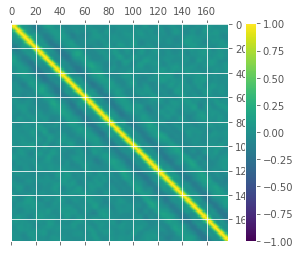

In [0]:
correlations = raw.drop(columns='y').corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

# Split data and PCA Transformation

## Split and Standardize for Binary Classification

In [0]:
X = raw.drop(columns='y')
y = raw['y'].apply(lambda x: 1 if x==1 else 0)

In [0]:
X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [0]:
X_valid, X_test, y_valid, y_test = train_test_split(X_t, y_t, test_size=0.5, random_state=42, stratify=y_t)

In [0]:
bscaler = StandardScaler()
bscaler.fit(X_train)
X_train = bscaler.transform(X_train)
X_valid = bscaler.transform(X_valid)
X_test = bscaler.transform(X_test)

## Split and Standardize for 5-class Classification

In [0]:
Xm = raw.drop(columns='y')
ym = raw['y']

In [0]:
Xm_train, Xm_t, ym_train, ym_t = train_test_split(Xm, ym, test_size=0.3, random_state=42, stratify=ym)

In [0]:
Xm_valid, Xm_test, ym_valid, ym_test = train_test_split(Xm_t, ym_t, test_size=0.5, random_state=42, stratify=ym_t)

In [0]:
mscaler = StandardScaler()
mscaler.fit(Xm_train)
Xm_train = mscaler.transform(Xm_train)
Xm_valid = mscaler.transform(Xm_valid)
Xm_test = mscaler.transform(Xm_test) 

## PCA Fit and Transformation

### PCA for Binary Classification

Loading Matrix:
           PC1       PC2       PC3  ...     PC176     PC177     PC178
X1   -0.024361  0.106342  0.078809  ...  0.000354 -0.000260  0.000136
X2   -0.013806  0.142007  0.063134  ... -0.001122  0.000985 -0.000258
X3   -0.003578  0.184148  0.039681  ...  0.000697 -0.001073 -0.000186
X4    0.008878  0.220950  0.010910  ...  0.001516 -0.000404  0.001065
X5    0.018086  0.253224 -0.019355  ... -0.002599  0.001717 -0.001075
X6    0.024359  0.282108 -0.052530  ...  0.000457 -0.000489 -0.000581
X7    0.018087  0.299310 -0.084502  ...  0.002190 -0.001843  0.002026
X8    0.004598  0.300409 -0.114964  ... -0.001457  0.001861 -0.001305
X9   -0.016944  0.285047 -0.147512  ... -0.001651  0.000164 -0.000194
X10  -0.039097  0.256795 -0.177429  ...  0.002361 -0.001053  0.000314
X11  -0.062119  0.214114 -0.200204  ...  0.000283  0.000087  0.000300
X12  -0.083501  0.161189 -0.212799  ... -0.002316  0.000671 -0.000106
X13  -0.097162  0.100557 -0.216534  ...  0.000796 -0.000071 -0.000691
X14 

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


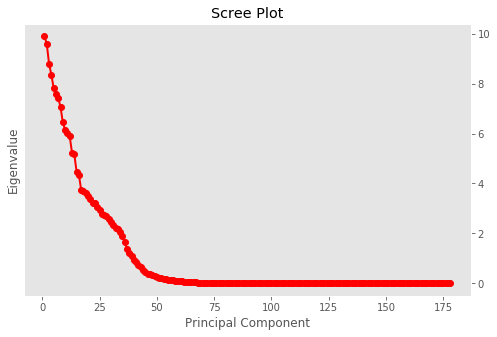

In [0]:
features = list(X)
colnames = np.transpose(features)

#Apply PCA. Get Eigenvctors, Eigenvalues
n_components = len(features)
pca = PCA(n_components).fit(X_train)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_
    
# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
print('Loading Matrix:'); loadings= np.sqrt(eigval)*eigvec
print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

# Print out Eigenvectors
print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 45 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')

# scree plot
num_vars= len(features)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(); plt.show()


### PCA for 5-class Classification

Loading Matrix:
           PC1       PC2       PC3  ...     PC176     PC177     PC178
X1   -0.015419 -0.108733  0.041714  ...  0.000180  0.000175  0.000169
X2   -0.052959 -0.120681  0.023813  ... -0.000405 -0.000752 -0.000425
X3   -0.094018 -0.136829  0.003110  ... -0.000183  0.000989 -0.000339
X4   -0.136026 -0.148143 -0.016508  ...  0.001575  0.000204  0.002124
X5   -0.172025 -0.153366 -0.030057  ... -0.001761 -0.001503 -0.002514
X6   -0.201706 -0.152922 -0.039347  ... -0.000587  0.000614  0.000116
X7   -0.218198 -0.148413 -0.048703  ...  0.002913  0.001043  0.002143
X8   -0.222590 -0.132378 -0.064282  ... -0.001607 -0.000642 -0.001207
X9   -0.217474 -0.101762 -0.092767  ... -0.002174 -0.001104 -0.001044
X10  -0.208099 -0.059924 -0.136442  ...  0.002637  0.001357  0.000928
X11  -0.184778 -0.008748 -0.182838  ...  0.001845  0.000036  0.001083
X12  -0.152076  0.037592 -0.215666  ... -0.005136 -0.000693 -0.001649
X13  -0.113334  0.077825 -0.224854  ...  0.002039 -0.000150 -0.000112
X14 

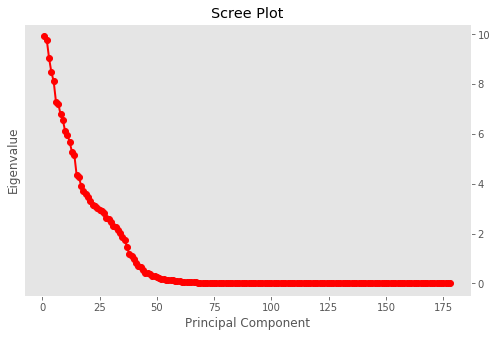

In [0]:
features = list(Xm)
colnames = np.transpose(features)

#Apply PCA. Get Eigenvctors, Eigenvalues
n_components = len(features)
pca = PCA(n_components).fit(Xm_train)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_
    
# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
print('Loading Matrix:'); loadings= np.sqrt(eigval)*eigvec
print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

# Print out Eigenvectors
print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 45 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')

# scree plot
num_vars= len(features)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(); plt.show()


Notes:  
- PCA components for binary classification: 39
- PCA components for 5-class classification: 40

In [0]:
bpca = PCA(n_components=39)
X_train = bpca.fit_transform(X_train)
X_valid = bpca.transform(X_valid)
X_test = bpca.transform(X_test)

In [0]:
mpca = PCA(n_components=40)
Xm_train = mpca.fit_transform(Xm_train)
Xm_valid = mpca.transform(Xm_valid)
Xm_test = mpca.transform(Xm_test)

# Decision Tree

## Binary Classification

### Model Training and Validation

[[1353   27]
 [  54  291]]
 
Best accuracy (on testing dataset): 95.30%
 
              precision    recall  f1-score   support

           0     0.9616    0.9804    0.9709      1380
           1     0.9151    0.8435    0.8778       345

    accuracy                         0.9530      1725
   macro avg     0.9384    0.9120    0.9244      1725
weighted avg     0.9523    0.9530    0.9523      1725



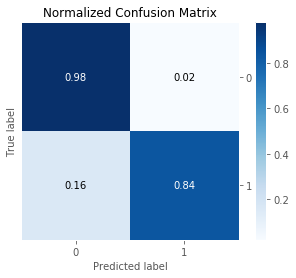

In [0]:
binaryModel = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0)
binaryModel.fit(X_train, y_train)  
y_pred = binaryModel.predict(X_valid)  

print(metrics.confusion_matrix(y_valid,y_pred))  
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(y_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(y_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(y_valid, y_pred, normalize=True) 

In [0]:
metrics.roc_auc_score(y_valid, y_pred)

0.9119565217391304

## 5-class Classification

### Model Training and Validation

[[285  23  10  24   3]
 [ 22 153 113  20  37]
 [  9 111 150  27  48]
 [ 15  37  32 183  78]
 [  4  43  57  81 160]]
 
Best accuracy (on testing dataset): 53.97%
 
              precision    recall  f1-score   support

           1     0.8507    0.8261    0.8382       345
           2     0.4169    0.4435    0.4298       345
           3     0.4144    0.4348    0.4243       345
           4     0.5463    0.5304    0.5382       345
           5     0.4908    0.4638    0.4769       345

    accuracy                         0.5397      1725
   macro avg     0.5438    0.5397    0.5415      1725
weighted avg     0.5438    0.5397    0.5415      1725



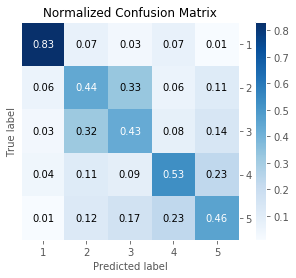

In [0]:
multiModel = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, random_state=0)
multiModel.fit(Xm_train, ym_train)  
y_pred = multiModel.predict(Xm_valid)  

print(metrics.confusion_matrix(ym_valid,y_pred))  
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(ym_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(ym_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(ym_valid, y_pred, normalize=True) 

# Bagging

## Binary Classification

### Model Training and Validation

[[1363   17]
 [  21  324]]
 
Best accuracy (on testing dataset): 97.80%
 
              precision    recall  f1-score   support

           0     0.9848    0.9877    0.9863      1380
           1     0.9501    0.9391    0.9446       345

    accuracy                         0.9780      1725
   macro avg     0.9675    0.9634    0.9654      1725
weighted avg     0.9779    0.9780    0.9779      1725



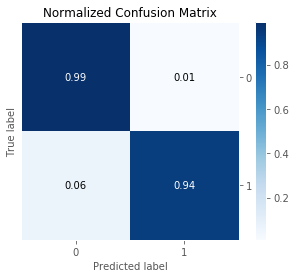

In [0]:
binaryModel = BaggingClassifier(n_estimators=100, bootstrap_features=True, random_state=0)
binaryModel.fit(X_train, y_train)  
y_pred = binaryModel.predict(X_valid)  

print(metrics.confusion_matrix(y_valid,y_pred))  
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(y_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(y_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(y_valid, y_pred, normalize=True) 

In [0]:
metrics.roc_auc_score(y_valid, y_pred)

0.9626811594202899

## 5-class Classification

### Model Training and Validation

[[329   7   1   8   0]
 [ 28 182  94  14  27]
 [  7  70 213  23  32]
 [  3   8   2 254  78]
 [  0  17  30  82 216]]
 
Best accuracy (on testing dataset): 69.22%
 
              precision    recall  f1-score   support

           1     0.8965    0.9536    0.9242       345
           2     0.6408    0.5275    0.5787       345
           3     0.6265    0.6174    0.6219       345
           4     0.6667    0.7362    0.6997       345
           5     0.6119    0.6261    0.6189       345

    accuracy                         0.6922      1725
   macro avg     0.6885    0.6922    0.6887      1725
weighted avg     0.6885    0.6922    0.6887      1725



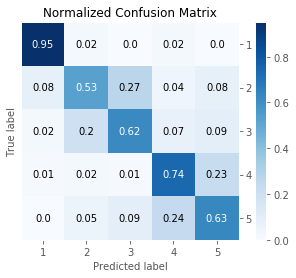

In [0]:
multiModel = BaggingClassifier(n_estimators=100, oob_score=True, bootstrap_features=True, random_state=0)
multiModel.fit(Xm_train, ym_train)  
y_pred = multiModel.predict(Xm_valid)  

print(metrics.confusion_matrix(ym_valid,y_pred))  
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(ym_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(ym_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(ym_valid, y_pred, normalize=True) 

# Random Forest

## Binary Classification

### Model Training and Validation

[[1361   19]
 [  24  321]]
 
Best accuracy (on testing dataset): 97.51%
 
              precision    recall  f1-score   support

           0     0.9827    0.9862    0.9844      1380
           1     0.9441    0.9304    0.9372       345

    accuracy                         0.9751      1725
   macro avg     0.9634    0.9583    0.9608      1725
weighted avg     0.9750    0.9751    0.9750      1725



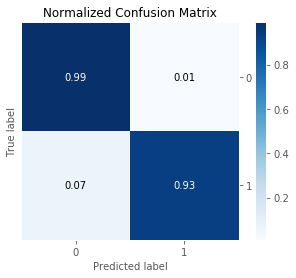

In [0]:
binaryModel = RandomForestClassifier(n_estimators=190,criterion='entropy',bootstrap=False, min_samples_leaf=2, random_state=0)
binaryModel.fit(X_train, y_train)  
y_pred = binaryModel.predict(X_valid)  

print(metrics.confusion_matrix(y_valid,y_pred))  
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(y_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(y_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(y_valid, y_pred, normalize=True) 

In [0]:
metrics.roc_auc_score(y_valid, y_pred)

0.9568840579710146

## 5-class Classification

### Model Training and Validation

[[331   6   2   6   0]
 [ 25 187  86  11  36]
 [  5  60 226  19  35]
 [  2   3   4 264  72]
 [  0   8  24  55 258]]
 
Best accuracy (on testing dataset): 73.39%
 
              precision    recall  f1-score   support

           1     0.9118    0.9594    0.9350       345
           2     0.7083    0.5420    0.6141       345
           3     0.6608    0.6551    0.6579       345
           4     0.7437    0.7652    0.7543       345
           5     0.6434    0.7478    0.6917       345

    accuracy                         0.7339      1725
   macro avg     0.7336    0.7339    0.7306      1725
weighted avg     0.7336    0.7339    0.7306      1725



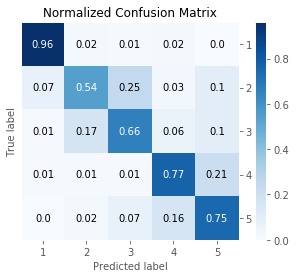

In [0]:
multiModel = RandomForestClassifier(n_estimators=190,criterion='entropy',bootstrap=False, min_samples_leaf=2,random_state=0)
multiModel.fit(Xm_train, ym_train)  
y_pred = multiModel.predict(Xm_valid)  

print(metrics.confusion_matrix(ym_valid,y_pred))
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(ym_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(ym_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(ym_valid, y_pred, normalize=True) 

# Logistic Regression

## Binary Classification

### Model Training and Validation

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', 
                            dual=False, 
                            tol=0.0001, 
                            C=0.0001, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=42, 
                            solver='liblinear',
                            max_iter=100, 
                            ) 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

[[1375    5]
 [ 283   62]]
 
Best accuracy (on testing dataset): 83.30%
 
              precision    recall  f1-score   support

           0     0.8293    0.9964    0.9052      1380
           1     0.9254    0.1797    0.3010       345

    accuracy                         0.8330      1725
   macro avg     0.8773    0.5880    0.6031      1725
weighted avg     0.8485    0.8330    0.7844      1725



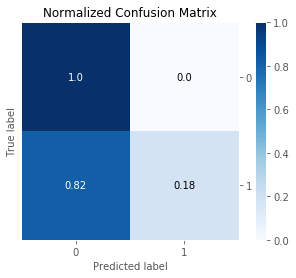

In [0]:
print(metrics.confusion_matrix(y_valid,y_pred))
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(y_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(y_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(y_valid, y_pred, normalize=True) 

In [0]:
metrics.roc_auc_score(y_valid, y_pred)

0.5880434782608696

## 5-class Classification

### Model Training and Validation

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2', 
                            dual=False, 
                            tol=0.0001, 
                            C=0.001, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=None, 
                            solver='lbfgs',
                            max_iter=100, 
                            multi_class='multinomial', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=None, 
                            l1_ratio=None)
logreg.fit(Xm_train, ym_train)
y_train_pred = logreg.predict(Xm_train)
y_valid_pred = logreg.predict(Xm_valid)

[[124  64  31  88  38]
 [ 75  68  34 124  44]
 [ 68  72  39 126  40]
 [ 84  53  23 135  50]
 [ 72  74  21 117  61]]
 
Best accuracy (on valid dataset): 24.75%
 
              precision    recall  f1-score   support

           1     0.2931    0.3594    0.3229       345
           2     0.2054    0.1971    0.2012       345
           3     0.2635    0.1130    0.1582       345
           4     0.2288    0.3913    0.2888       345
           5     0.2618    0.1768    0.2111       345

    accuracy                         0.2475      1725
   macro avg     0.2505    0.2475    0.2364      1725
weighted avg     0.2505    0.2475    0.2364      1725



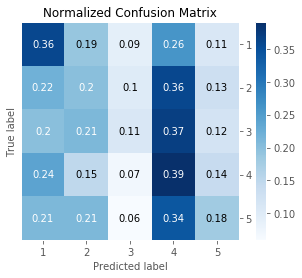

In [0]:
print(metrics.confusion_matrix(ym_valid,y_valid_pred))
print(" ")

print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(ym_valid, y_valid_pred)*100))
print(" ")
print(metrics.classification_report(ym_valid, y_valid_pred,digits=4))
skplt.metrics.plot_confusion_matrix(ym_valid, y_valid_pred, normalize=True) 

# Gradient Boosting

## Binary Classification

[[1365   15]
 [  26  319]]
 
Best accuracy (on testing dataset): 97.62%
 
              precision    recall  f1-score   support

           0     0.9813    0.9891    0.9852      1380
           1     0.9551    0.9246    0.9396       345

    accuracy                         0.9762      1725
   macro avg     0.9682    0.9569    0.9624      1725
weighted avg     0.9761    0.9762    0.9761      1725



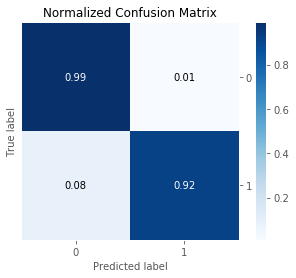

In [0]:
from xgboost import XGBClassifier


model = XGBClassifier(n_estimators=100,
                      objective ='binary:logistic',
                      learning_rate=0.1,
                      gamma=0, 
                      subsample=0.75,
                      colsample_bytree=1,
                      max_depth=5,
                      min_weight=1, 
                      random_state=42,
                      )
model.fit(X_train, y_train)  
y_pred = model.predict(X_valid)  

print(metrics.confusion_matrix(y_valid,y_pred))
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(y_valid, y_pred)*100))
print(" ")
print(metrics.classification_report(y_valid, y_pred,digits=4))
skplt.metrics.plot_confusion_matrix(y_valid, y_pred, normalize=True) 

## 5-class Classification XGBoost(gblinear booster) 

### Model Training and Validation

In [0]:
import time 
start =time.clock()

model = XGBClassifier(n_estimators=100,
                      objective ='multi:softmax',
                      learning_rate=0.1,
                      gamma=0, 
                      subsample=0.75,
                      colsample_bytree=1,
                      max_depth=5,
                      min_weight=1, 
                      random_state=42,
                      booster='gblinear',
                      num_class=5
                      )

model.fit(Xm_train,ym_train)
y_train_pred = model.predict(Xm_train)
y_valid_pred = model.predict(Xm_valid)

end = time.clock()
print('Running time: %s Seconds'%(end-start))

accuracy:0.242
accuracy:0.242
Running time: 2.3046380000000113 Seconds


[[134  60  25  96  30]
 [ 97  61  27 129  31]
 [ 88  65  36 129  27]
 [104  46  20 140  35]
 [ 86  76  12 124  47]]
 
Best accuracy (on testing dataset): 24.23%
 
              precision    recall  f1-score   support

           1     0.2633    0.3884    0.3138       345
           2     0.1981    0.1768    0.1868       345
           3     0.3000    0.1043    0.1548       345
           4     0.2265    0.4058    0.2908       345
           5     0.2765    0.1362    0.1825       345

    accuracy                         0.2423      1725
   macro avg     0.2529    0.2423    0.2258      1725
weighted avg     0.2529    0.2423    0.2258      1725



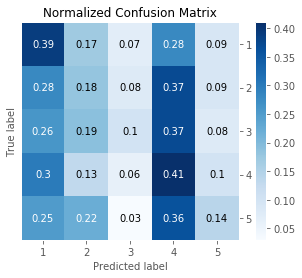

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(Xm_valid)

print(metrics.confusion_matrix(ym_valid,y_valid_pred))
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(ym_valid, y_valid_pred)*100))
print(" ")
print(metrics.classification_report(ym_valid, y_valid_pred,digits=4))
skplt.metrics.plot_confusion_matrix(ym_valid, y_valid_pred, normalize=True) 

## 5-class Classification XGBoost(gbtree booster) 

### Model Training and Validation

In [0]:
import time 
start =time.clock()


model = XGBClassifier(n_estimators=1000,
                      learning_rate=0.1,
                      gamma=0, 
                      subsample=0.75,
                      colsample_bytree=1,
                      max_depth=5,
                      min_weight=1, 
                      random_state=42,
                      booster='gbtree',
                      objective='multi：softmax',
                      )

model.fit(Xm_train,ym_train)
y_train_pred = model.predict(Xm_train)
y_valid_pred = model.predict(Xm_valid)


end = time.clock()
print('Running time: %s Seconds'%(end-start))

accuracy:1.000
accuracy:0.730
Running time: 149.342191 Seconds


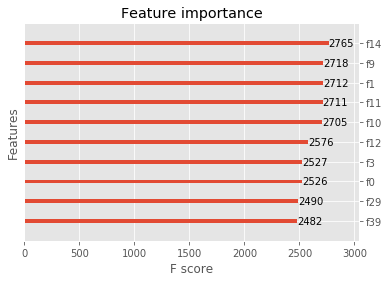

In [0]:
import xgboost 
from matplotlib import pyplot as plt
xgboost.plot_importance(model,max_num_features=10)
plt.show()

[[326   9   5   5   0]
 [ 15 198 110   4  18]
 [  4  91 214  13  23]
 [  2   6   4 259  74]
 [  0  14  19  50 262]]
 
Best accuracy (on testing dataset): 72.99%
 
              precision    recall  f1-score   support

           1     0.9395    0.9449    0.9422       345
           2     0.6226    0.5739    0.5973       345
           3     0.6080    0.6203    0.6141       345
           4     0.7825    0.7507    0.7663       345
           5     0.6950    0.7594    0.7258       345

    accuracy                         0.7299      1725
   macro avg     0.7295    0.7299    0.7291      1725
weighted avg     0.7295    0.7299    0.7291      1725



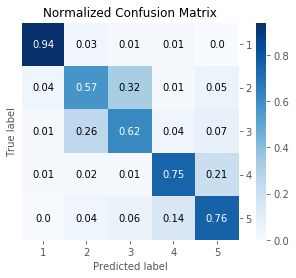

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(Xm_valid)

print(metrics.confusion_matrix(ym_valid,y_valid_pred))
print(" ")
print("Best accuracy (on validation dataset): %.2f%%" % (metrics.accuracy_score(ym_valid, y_valid_pred)*100))
print(" ")
print(metrics.classification_report(ym_valid, y_valid_pred,digits=4))
skplt.metrics.plot_confusion_matrix(ym_valid, y_valid_pred, normalize=True) 

# Multi-layer Perceptron

## Binary Classification

### Specific Pre-processing

In [0]:
y_train_b = y_train.to_numpy().reshape((y_train.shape[0],1))

In [0]:
y_valid_b = y_valid.to_numpy().reshape((y_valid.shape[0],1))

In [0]:
X_train.shape, y_train_b.shape

((8050, 39), (8050, 1))

### Modeling Training and Validation

In [0]:
def createBinaryModel():

    inp = Input(shape=(X_train.shape[1]))
    x = Dense(32, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    # process model
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [0]:
binarymodel = createBinaryModel()
binarymodelGo = createBinaryModel()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
binarymodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 39)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________


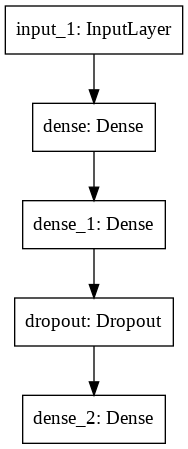

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(binarymodel, to_file='binarymodel.png')

In [0]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
modelname       = "binarymodel"
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [0]:
                            # Fit the model
                            # This is where the training starts
binarymodel.fit(X_train, 
                y_train_b, 
                validation_data=(X_valid, y_valid_b), 
                epochs=40, 
                batch_size=64,
                shuffle=True,
                callbacks=callbacks_list)

Train on 8050 samples, validate on 1725 samples
Epoch 1/40
8050/8050 [==============================] - 1s 181us/sample - loss: 0.7522 - acc: 0.7491 - val_loss: 0.4938 - val_acc: 0.8835
Epoch 2/40
8050/8050 [==============================] - 1s 71us/sample - loss: 0.4467 - acc: 0.8781 - val_loss: 0.3009 - val_acc: 0.9391
Epoch 3/40
8050/8050 [==============================] - 1s 70us/sample - loss: 0.2850 - acc: 0.9260 - val_loss: 0.1854 - val_acc: 0.9519
Epoch 4/40
8050/8050 [==============================] - 1s 69us/sample - loss: 0.2007 - acc: 0.9416 - val_loss: 0.1354 - val_acc: 0.9577
Epoch 5/40
8050/8050 [==============================] - 1s 67us/sample - loss: 0.1571 - acc: 0.9537 - val_loss: 0.1164 - val_acc: 0.9612
Epoch 6/40
8050/8050 [==============================] - 1s 69us/sample - loss: 0.1308 - acc: 0.9589 - val_loss: 0.1051 - val_acc: 0.9623
Epoch 7/40
8050/8050 [==============================] - 1s 71us/sample - loss: 0.1176 - acc: 0.9668 - val_loss: 0.0991 - val_acc:

In [0]:
binarymodelGo.load_weights(filepath)
binarymodelGo.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

In [0]:
predicts    = binarymodelGo.predict(X_valid)
predout     = np.where(predicts.reshape(-1) > 0.5, 1, 0)
testout     = y_valid_b.reshape(-1)

In [0]:
binarymodelGo.evaluate(X_valid, y_valid_b, batch_size=128)

1725/1725 [==============================] - 0s 37us/sample - loss: 0.0748 - acc: 0.9768


[0.07475679881114891, 0.9768116]

In [0]:
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)

In [0]:
print("Best accuracy (on validation dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,digits=4))
print(confusion)

Best accuracy (on testing dataset): 97.68%
              precision    recall  f1-score   support

           0     0.9841    0.9870    0.9855      1380
           1     0.9472    0.9362    0.9417       345

    accuracy                         0.9768      1725
   macro avg     0.9657    0.9616    0.9636      1725
weighted avg     0.9767    0.9768    0.9768      1725

[[1362   18]
 [  22  323]]


In [0]:
metrics.roc_auc_score(testout, predicts)

0.9935118672547784

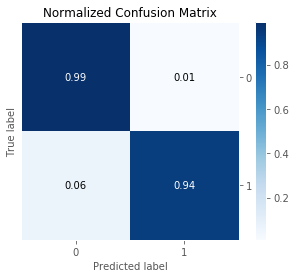

In [0]:
skplt.metrics.plot_confusion_matrix(testout, predout, normalize=True)

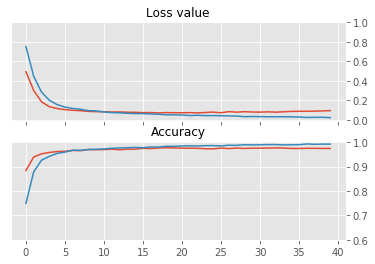

In [0]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

## 5-class Classification - MLP

### 5-class specific pre-processing

In [0]:
from tensorflow.keras.utils import to_categorical
ym_train_c = to_categorical(ym_train-1)
ym_valid_c = to_categorical(ym_valid-1)
ym_test_c = to_categorical(ym_test-1)

In [0]:
Xm_train.shape, ym_train_c.shape

((8050, 40), (8050, 5))

### Model Training and Validation

In [0]:
def createMultiMLPModel():

    inp = Input(shape=(Xm_train.shape[1]))
    x = Dense(32, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='softmax')(x)
    
    # process model
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [0]:
multiMLPModel = createMultiMLPModel()
multiMLPModelGo = createMultiMLPModel()

In [0]:
multiMLPModel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 165       
Total params: 2,533
Trainable params: 2,533
Non-trainable params: 0
_________________________________________________________________


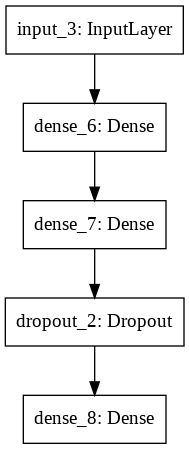

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(multiMLPModel, to_file='multiMLPModel.png')

In [0]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
modelname       = "multiMLPModel"
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [0]:
                            # Fit the model
                            # This is where the training starts
multiMLPModel.fit(Xm_train, 
                  ym_train_c, 
                  validation_data=(Xm_valid, ym_valid_c), 
                  epochs=50, 
                  batch_size=32,
                  shuffle=True,
                  callbacks=callbacks_list)

Train on 8050 samples, validate on 1725 samples
Epoch 1/50
8050/8050 [==============================] - 1s 160us/sample - loss: 1.6031 - acc: 0.2665 - val_loss: 1.3712 - val_acc: 0.3797
Epoch 2/50
8050/8050 [==============================] - 1s 127us/sample - loss: 1.3637 - acc: 0.3723 - val_loss: 1.2846 - val_acc: 0.4441
Epoch 3/50
8050/8050 [==============================] - 1s 128us/sample - loss: 1.2805 - acc: 0.4317 - val_loss: 1.2125 - val_acc: 0.4962
Epoch 4/50
8050/8050 [==============================] - 1s 128us/sample - loss: 1.2138 - acc: 0.4583 - val_loss: 1.1529 - val_acc: 0.5107
Epoch 5/50
8050/8050 [==============================] - 1s 131us/sample - loss: 1.1603 - acc: 0.4773 - val_loss: 1.0951 - val_acc: 0.5287
Epoch 6/50
8050/8050 [==============================] - 1s 127us/sample - loss: 1.1022 - acc: 0.5070 - val_loss: 1.0415 - val_acc: 0.5513
Epoch 7/50
8050/8050 [==============================] - 1s 127us/sample - loss: 1.0630 - acc: 0.5195 - val_loss: 0.9920 - va

In [0]:
multiMLPModelGo.load_weights(filepath)
multiMLPModelGo.compile(loss='categorical_crossentropy', 
                        optimizer='adam', 
                        metrics=['accuracy'])

In [0]:
mpredicts    = multiMLPModel.predict(Xm_valid)
mpredout     = np.argmax(mpredicts,axis=1)
mtestout     = np.argmax(ym_valid_c,axis=1)

In [0]:
mtestScores  = metrics.accuracy_score(mtestout,mpredout)
mconfusion   = metrics.confusion_matrix(mtestout,mpredout)

In [0]:
print("Best accuracy (on validation dataset): %.2f%%" % (mtestScores*100))
print(metrics.classification_report(mtestout,mpredout,digits=4))
print(mconfusion)

Best accuracy (on testing dataset): 65.22%
              precision    recall  f1-score   support

           0     0.9472    0.9362    0.9417       345
           1     0.5131    0.2841    0.3657       345
           2     0.4697    0.6957    0.5607       345
           3     0.7884    0.6696    0.7241       345
           4     0.5990    0.6754    0.6349       345

    accuracy                         0.6522      1725
   macro avg     0.6635    0.6522    0.6454      1725
weighted avg     0.6635    0.6522    0.6454      1725

[[323  14   2   6   0]
 [ 12  98 204   3  28]
 [  0  66 240   3  36]
 [  6   7   9 231  92]
 [  0   6  56  50 233]]


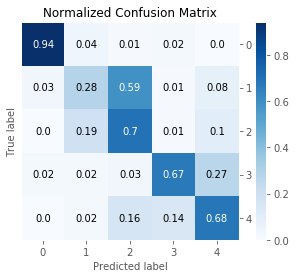

In [0]:
skplt.metrics.plot_confusion_matrix(mtestout, mpredout, normalize=True)

# Convolutional Neural Network
- note not required for binary class due to accuracy rates achieved

## 5-class classification

### Specific pre-processing

In [0]:
Xm_train2 = Xm_train.reshape((8050, 40,1))
Xm_valid2 = Xm_valid.reshape((1725, 40,1))

In [0]:
Xm_train2.shape, Xm_valid2.shape, ym_train_c.shape, ym_valid_c.shape

((8050, 40, 1), (1725, 40, 1), (8050, 5), (1725, 5))

### Model training and validation

In [0]:
def createMultiConvModel():

    inp = Input(shape=(Xm_train2.shape[1],Xm_train2.shape[2]))
    x = Conv1D(48, 3, padding='same')(inp)
    x = Conv1D(64, 3, padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='softmax')(x)
    
    # process model
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [0]:
multiConvModel = createMultiConvModel()
multiConvModelGo = createMultiConvModel()

In [0]:
multiConvModel.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 48)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 64)            9280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1639

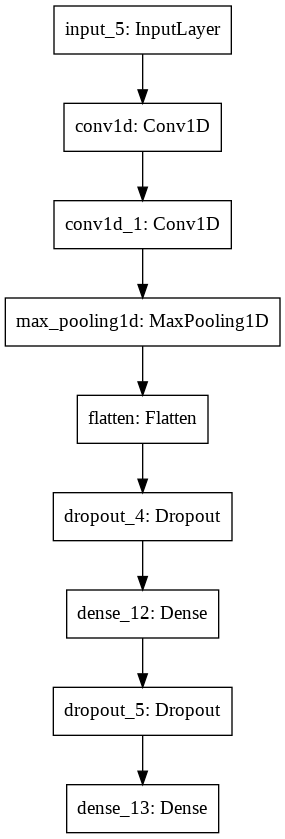

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(multiConvModel, to_file='multiConvModel.png')

In [0]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
modelname       = "multiconvmodel"
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [0]:
multiConvModel.fit(Xm_train2, 
                   ym_train_c, 
                   validation_data=(Xm_valid2, ym_valid_c), 
                   epochs=60, 
                   batch_size=32,
                   shuffle=True,
                   callbacks=callbacks_list)

Train on 8050 samples, validate on 1725 samples
Epoch 1/60
8050/8050 [==============================] - 4s 516us/sample - loss: 1.0144 - acc: 0.5496 - val_loss: 0.8047 - val_acc: 0.6284
Epoch 2/60
8050/8050 [==============================] - 2s 190us/sample - loss: 0.8397 - acc: 0.6265 - val_loss: 0.7543 - val_acc: 0.6609
Epoch 3/60
8050/8050 [==============================] - 2s 187us/sample - loss: 0.7855 - acc: 0.6439 - val_loss: 0.7398 - val_acc: 0.6667
Epoch 4/60
8050/8050 [==============================] - 2s 187us/sample - loss: 0.7602 - acc: 0.6599 - val_loss: 0.7277 - val_acc: 0.6794
Epoch 5/60
8050/8050 [==============================] - 1s 184us/sample - loss: 0.7385 - acc: 0.6661 - val_loss: 0.7094 - val_acc: 0.6800
Epoch 6/60
8050/8050 [==============================] - 2s 188us/sample - loss: 0.7294 - acc: 0.6725 - val_loss: 0.6867 - val_acc: 0.6864
Epoch 7/60
8050/8050 [==============================] - 1s 182us/sample - loss: 0.7041 - acc: 0.6826 - val_loss: 0.7055 - va

In [0]:
multiConvModelGo.load_weights(filepath)
multiConvModelGo.compile(loss='categorical_crossentropy', 
                         optimizer='adam', 
                         metrics=['accuracy'])

In [0]:
mcpredicts    = multiConvModel.predict(Xm_valid2)
mcpredout     = np.argmax(mcpredicts,axis=1)
mctestout     = np.argmax(ym_valid_c,axis=1)

In [0]:
mctestScores  = metrics.accuracy_score(mctestout,mcpredout)
mcconfusion   = metrics.confusion_matrix(mctestout,mcpredout)

In [0]:
print("Best accuracy (on validation dataset): %.2f%%" % (mctestScores*100))
print(metrics.classification_report(mctestout,mcpredout,digits=4))
print(mcconfusion)

Best accuracy (on testing dataset): 71.48%
              precision    recall  f1-score   support

           0     0.9563    0.9507    0.9535       345
           1     0.5897    0.5623    0.5757       345
           2     0.5568    0.5826    0.5694       345
           3     0.8322    0.7333    0.7797       345
           4     0.6624    0.7449    0.7012       345

    accuracy                         0.7148      1725
   macro avg     0.7195    0.7148    0.7159      1725
weighted avg     0.7195    0.7148    0.7159      1725

[[328  10   5   2   0]
 [  9 194 122   0  20]
 [  3 101 201  10  30]
 [  3   5   3 253  81]
 [  0  19  30  39 257]]


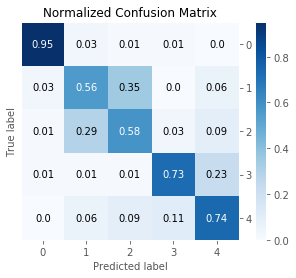

In [0]:
skplt.metrics.plot_confusion_matrix(mctestout, mcpredout, normalize=True)

# Voting Multi-Classifier

In [0]:
rfc = RandomForestClassifier(n_estimators=190,criterion='entropy',bootstrap=False, min_samples_leaf=2,random_state=0)

In [0]:
xgbc = XGBClassifier(n_estimators=1000,
                      learning_rate=0.1,
                      gamma=0, 
                      subsample=0.75,
                      colsample_bytree=1,
                      max_depth=5,
                      min_weight=1, 
                      random_state=27,
                      booster='gbtree',
                      )

Recode to Sequential for KerasClassifier to use predict_classes function with VotingClassifier

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential

def kerasConv():

    model = Sequential()
    model.add(Conv1D(32, 3, padding='same',
                     input_shape=(40,1)))
    model.add(Conv1D(64, 3, padding='same'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

kerasConvModel = KerasClassifier(build_fn=kerasConv, epochs=60, 
                                 batch_size=32, verbose=0)

In [0]:
from sklearn.preprocessing import LabelEncoder

def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):

    le_ = LabelEncoder()
    le_.fit(y)
    transformed_y = le_.transform(y)
    estimators_ = []
    
    for clf, X in zip([clf for _, clf in classifiers], X_list):
        if sample_weights is None:
            clf.fit(X, y)
        else:
            clf.fit(X, y, sample_weights)
        estimators_.append(clf)


    return estimators_, le_


def predict_from_multiple_estimator(estimators, label_encoder, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)

    return label_encoder.inverse_transform(pred)

In [0]:
estimators=[('rfc', rfc), ('xgbc',xgbc), ('kerasConvModel', kerasConvModel)]
X_train_list = [Xm_train, Xm_train, Xm_train2]
X_valid_list = [Xm_valid, Xm_valid, Xm_valid2]

In [0]:
fitted_estimators, label_encoder = fit_multiple_estimators(estimators, X_train_list, ym_train)

In [0]:
y_pred = predict_from_multiple_estimator(fitted_estimators, label_encoder, X_valid_list)

In [0]:
vctestScores  = metrics.accuracy_score(ym_valid,y_pred)
vcconfusion   = metrics.confusion_matrix(ym_valid,y_pred)

In [0]:
print("Best accuracy (on validation dataset): %.2f%%" % (vctestScores*100))
print(metrics.classification_report(ym_valid,y_pred,digits=4))
print(vcconfusion)

Best accuracy (on testing dataset): 74.43%
              precision    recall  f1-score   support

           1     0.9509    0.9536    0.9522       345
           2     0.6574    0.5507    0.5994       345
           3     0.6313    0.6551    0.6430       345
           4     0.8451    0.7275    0.7819       345
           5     0.6621    0.8348    0.7385       345

    accuracy                         0.7443      1725
   macro avg     0.7494    0.7443    0.7430      1725
weighted avg     0.7494    0.7443    0.7430      1725

[[329   8   4   4   0]
 [ 14 190 110   2  29]
 [  3  75 226  12  29]
 [  0   4   1 251  89]
 [  0  12  17  28 288]]


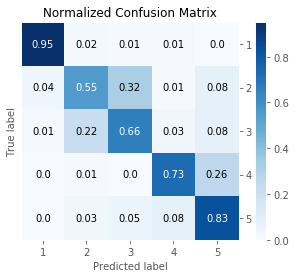

In [0]:
skplt.metrics.plot_confusion_matrix(ym_valid, y_pred, normalize=True)

# Final Score on Test Set

## Binary Classification

Choose Multi-Layer Perceptron based on highest ROC AUC score


In [0]:
y_test_b = y_test.to_numpy().reshape((y_test.shape[0],1))

predicts    = binarymodelGo.predict(X_test)
predout     = np.where(predicts.reshape(-1) > 0.5, 1, 0)
testout     = y_test_b.reshape(-1)

In [0]:
binarymodelGo.evaluate(X_test, y_test_b, batch_size=128)

1725/1725 [==============================] - 0s 21us/sample - loss: 0.1045 - acc: 0.9693


[0.10451998895493106, 0.96927536]

In [0]:
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)

In [0]:
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,digits=4))
print(confusion)

Best accuracy (on testing dataset): 96.93%
              precision    recall  f1-score   support

           0     0.9777    0.9841    0.9809      1380
           1     0.9345    0.9101    0.9222       345

    accuracy                         0.9693      1725
   macro avg     0.9561    0.9471    0.9515      1725
weighted avg     0.9691    0.9693    0.9691      1725

[[1358   22]
 [  31  314]]


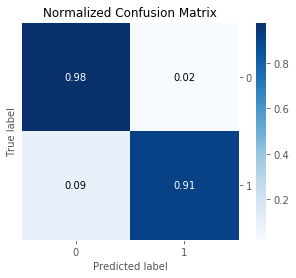

In [0]:
skplt.metrics.plot_confusion_matrix(testout, predout, normalize=True)

## 5-class Classification

In [0]:
Xm_test.shape

(1725, 40)

In [0]:
Xm_test2 = Xm_test.reshape((1725, 40,1))

In [0]:
X_test_list = [Xm_test, Xm_test, Xm_test2]

In [0]:
y_test_pred = predict_from_multiple_estimator(fitted_estimators, label_encoder, X_test_list)

In [0]:
ttestScores  = metrics.accuracy_score(ym_test,y_test_pred)
tconfusion   = metrics.confusion_matrix(ym_test,y_test_pred)

In [0]:
print("Best accuracy (on testing dataset): %.2f%%" % (ttestScores*100))
print(metrics.classification_report(ym_test,y_test_pred,digits=4))
print(tconfusion)

Best accuracy (on testing dataset): 74.61%
              precision    recall  f1-score   support

           1     0.9307    0.9739    0.9518       345
           2     0.6486    0.5565    0.5991       345
           3     0.6017    0.6087    0.6052       345
           4     0.8459    0.7797    0.8115       345
           5     0.6983    0.8116    0.7507       345

    accuracy                         0.7461      1725
   macro avg     0.7451    0.7461    0.7436      1725
weighted avg     0.7451    0.7461    0.7436      1725

[[336   6   1   2   0]
 [ 15 192 115   6  17]
 [  8  79 210  13  35]
 [  2   4   1 269  69]
 [  0  15  22  28 280]]


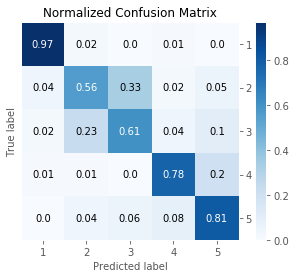

In [0]:
skplt.metrics.plot_confusion_matrix(ym_test, y_test_pred, normalize=True)